In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [18]:
!pip install scikit-image

In [8]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from image_utils import *
import mappings as mapps

In [9]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date
from scipy.ndimage import label
import time
from tqdm import tqdm
import os

In [10]:
update_storage_access()

In [11]:
environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

#2022
#guyane 2022
path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

#martinique 2022
path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]
          
#guadeloupe 2022
path_s3_pleiades_data_2022_guadeloupe = environment["sources"]["PLEIADES"][2022]["guadeloupe"]
path_local_pleiades_data_2022_guadeloupe = environment["local-path"]["PLEIADES"][2022]["guadeloupe"]

#mayotte 2022
path_s3_pleiades_data_2022_mayotte = environment["sources"]["PLEIADES"][2022]["mayotte"]
path_local_pleiades_data_2022_mayotte = environment["local-path"]["PLEIADES"][2022]["mayotte"]

#2020
#mayotte 2020
path_s3_pleiades_data_2020_mayotte = environment["sources"]["PLEIADES"][2020]["mayotte"]
path_local_pleiades_data_2020_mayotte = environment["local-path"]["PLEIADES"][2020]["mayotte"]

#2019
#mayotte 2019
path_s3_pleiades_data_2019_mayotte = environment["sources"]["PLEIADES"][2019]["mayotte"]
path_local_pleiades_data_2019_mayotte = environment["local-path"]["PLEIADES"][2019]["mayotte"]

#2018
#reunion 2018
path_s3_pleiades_data_2018_reunion = environment["sources"]["PLEIADES"][2018]["reunion"]
path_local_pleiades_data_2018_reunion = environment["local-path"]["PLEIADES"][2018]["reunion"]

#2017
#martinique 2017
path_s3_pleiades_data_2017_martinique = environment["sources"]["PLEIADES"][2017]["martinique"]
path_local_pleiades_data_2017_martinique = environment["local-path"]["PLEIADES"][2017]["martinique"]

#mayotte 2017
path_s3_pleiades_data_2017_mayotte = environment["sources"]["PLEIADES"][2017]["mayotte"]
path_local_pleiades_data_2017_mayotte = environment["local-path"]["PLEIADES"][2017]["mayotte"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [7]:
# DL PLEIADE mayotte 2020
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2020_mayotte}",
        lpath=f"../{path_local_pleiades_data_2020_mayotte}",
        recursive=True)

In [ ]:
# DL PLEIADE mayotte 2017
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_mayotte}",
        lpath=f"../{path_local_pleiades_data_2017_mayotte}",
        recursive=True)

In [9]:
# DL PLEIADE martinique 2022 utilisé !
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_martinique}",
        lpath=f"../{path_local_pleiades_data_2022_martinique}",
        recursive=True)

In [57]:
# DL PLEIADE martinique 2017 utilisé !
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_martinique}",
        lpath=f"../{path_local_pleiades_data_2017_martinique}",
        recursive=True)

In [6]:
# DL PLEIADE guyane 2022 utilisé !
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guyane}",
        lpath=f"../{path_local_pleiades_data_2022_guyane}",
        recursive=True)

En martinique :
(14.635338, -61.038345) plateau médico-technique construit en 2018 (côté droit du triangle). 
Essayons de retrouver l'image qui le contient.

In [210]:
#Nouvelle image 1
filename_1 = find_image_of_point([14.635338, -61.038345], '../data/PLEIADES/2022/MARTINIQUE', coord_gps = True)
date_1 = date.fromisoformat('2022-01-01')

In [129]:
image_1 = SatelliteImage.from_raster(
        filename_1,
        date = date_1, 
        n_bands = 3,
        dep = "972"
    )
image_1.normalize()

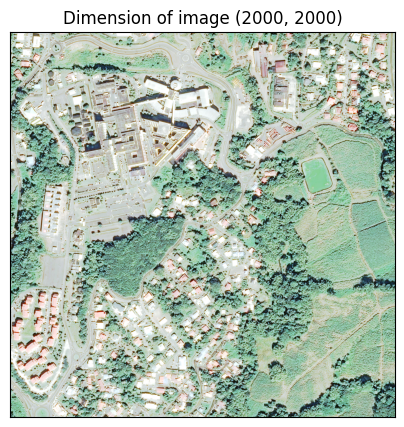

In [130]:
image_1.plot([0,1,2]) 

In [97]:
#image 2
filename_2 = find_image_different_years(2017, None, filename_1)
date_2 = date.fromisoformat('2017-01-01')

In [98]:
image_2 = SatelliteImage.from_raster(
        filename_2,
        date = date_2, 
        n_bands = 3,
        dep = "972"
    )
image_2.normalize()

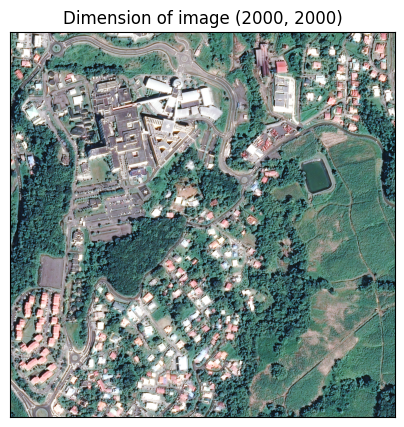

In [89]:
image_2.plot([0,1,2])

On a bien un changement à droite du triangle. Il ne reste plus qu'a avoir la bande infrarouge pour faire les masques puis les différences.

On va chercher en guyane : (-12.755601, 45.229945) coordonnées d'un quartier

In [132]:
filename_5 = find_image_of_point([-12.755601, 45.229945], '../data/PLEIADES/2020/MAYOTTE', coord_gps = True)
date_5 = date.fromisoformat('2020-01-01')

In [133]:
image_5 = SatelliteImage.from_raster(
        filename_5,
        date = date_5, 
        n_bands = 3,
        dep = "976"
    )
image_5.normalize()

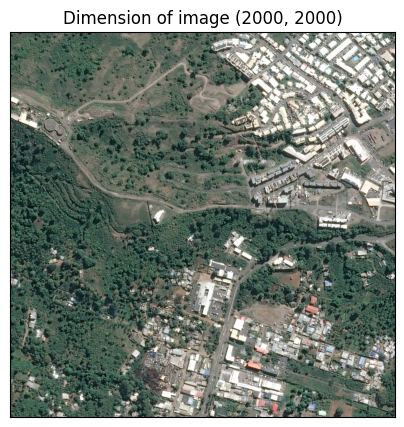

In [134]:
image_5.plot([0,1,2])

In [148]:
filename_6 = find_image_different_years(2017, image_5)
date_6 = date.fromisoformat('2020-01-01')

In [149]:
image_6 = SatelliteImage.from_raster(
        filename_6,
        date = date_6, 
        n_bands = 3,
        dep = "976"
    )
image_6.normalize()

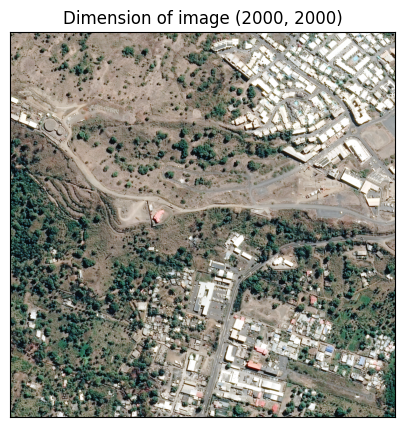

In [150]:
image_6.plot([0,1,2])

Dans la moitié haute de l'image à droite, il y a plusieurs bâtiments qui ont été construits.

Pas de RIL pour ces deux années en mayotte ...

In [12]:
filename_7 = find_image_of_point([-12.753436, 45.219888], '../data/PLEIADES/2020/MAYOTTE', coord_gps = True)
date_7 = date.fromisoformat('2020-01-01')

In [13]:
image_7 = SatelliteImage.from_raster(
        filename_7,
        date = date_7, 
        n_bands = 3,
        dep = "976"
    )
image_7.normalize()

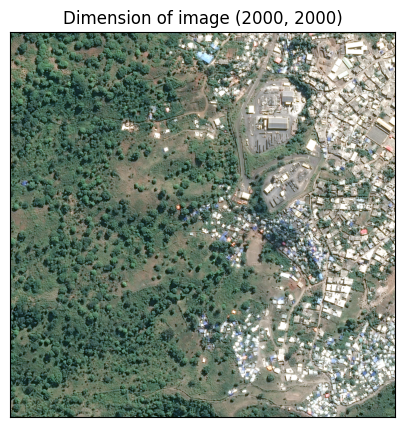

In [15]:
image_7.plot([0,1,2])

Export d'image

In [16]:
from PIL import Image
import numpy as np
import io

# Créer un tableau avec des données d'exemple
data = image_7.array
data = (data * 255).astype(np.uint8)
data = data.transpose(2,1,0)


# Convertir le tableau en image
image = Image.fromarray(data)

# Sauvegarder l'image en tant que fichier PNG
image.save("image.png")

# Enregistrer l'image en tant qu'objet bytes pour téléchargement
img_bytes = io.BytesIO()
image.save(img_bytes, format='PNG')
img_bytes.seek(0)

# Envoyer l'image pour téléchargement
from IPython.display import FileLink
display(FileLink("image.png"))

TypeError: Cannot handle this data type: (1, 1, 2000), |u1

In [16]:
filename_8 = find_image_different_years(2017, image_7)
date_8 = date.fromisoformat('2020-01-01')

In [17]:
image_8 = SatelliteImage.from_raster(
        filename_7,
        date = date_7, 
        n_bands = 3,
        dep = "976"
    )
image_8.normalize()

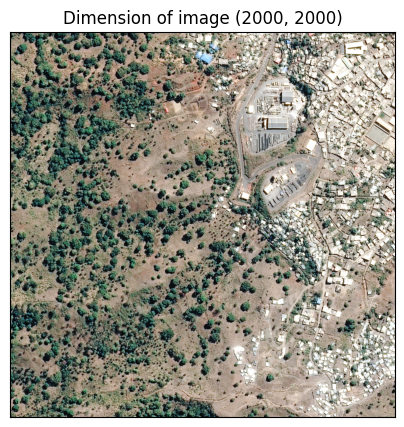

In [18]:
image_8.plot([0,1,2])